# 0. Install and Import Dependencies

In [1]:
# !pip list

In [2]:
# !pip install  matplotlib 


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

ModuleNotFoundError: No module named 'gdown'

In [ ]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

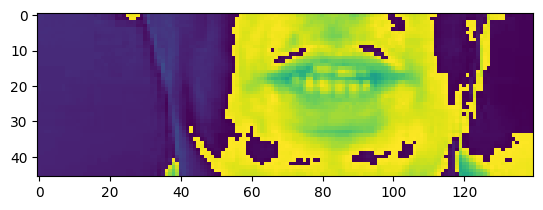

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val = sample.next(); val[0]

array([[[[[ 1.4522142 ],
          [ 1.4522142 ],
          [ 1.4107224 ],
          ...,
          [ 0.08298367],
          [ 0.08298367],
          [ 0.08298367]],

         [[ 1.4522142 ],
          [ 1.4522142 ],
          [ 1.4107224 ],
          ...,
          [ 0.08298367],
          [ 0.08298367],
          [ 0.08298367]],

         [[ 1.4107224 ],
          [ 1.4107224 ],
          [ 1.4107224 ],
          ...,
          [ 0.04149184],
          [ 0.04149184],
          [ 0.04149184]],

         ...,

         [[ 0.995804  ],
          [ 0.995804  ],
          [ 0.995804  ],
          ...,
          [10.331467  ],
          [10.331467  ],
          [10.331467  ]],

         [[ 0.995804  ],
          [ 0.995804  ],
          [ 0.995804  ],
          ...,
          [10.331467  ],
          [10.331467  ],
          [10.331467  ]],

         [[ 0.995804  ],
          [ 0.995804  ],
          [ 0.995804  ],
          ...,
          [10.331467  ],
          [10.331467  ],
          

In [32]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

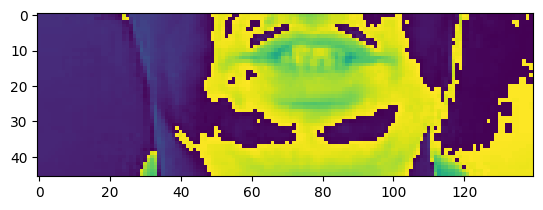

In [33]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [34]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in a zero now'>

# 3. Design the Deep Neural Network

In [35]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [36]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [37]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

N:\major project\lipnets\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [41]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3333333333334444444444444444444pp444444444ppppppppppppppppppppppppppppppp77'>

In [42]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'3333333333334444444444444444444pp444444444ppppppppppppppppppppppppppppppp77'>

In [43]:
model.input_shape

(None, 75, 46, 140, 1)

In [44]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [45]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [46]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [47]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [48]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [49]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.keras'), monitor='loss', save_weights_only=False) 

In [50]:
schedule_callback = LearningRateScheduler(scheduler)

In [51]:
example_callback = ProduceExample(test)

In [53]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [54]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [55]:
model.load_weights('models/checkpoint.weights.h5')

In [56]:
test_data = test.as_numpy_iterator()

In [57]:
sample = test_data.next()

In [58]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [59]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in y three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue in i two please'>]

In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [58]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' set red in u zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' lay white in y six now'>]

# Test on a Video

In [75]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf2n.mpg'))

In [76]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [77]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [78]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [79]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'le o'>]